In [1]:
def __return_waypoints_ind():
    d = np.array([
    [ 65, -36],
    [ 56, -21],
    [ 66, -46],
    [ 58, -48],
    [ 67, -29],
    [ 61, -16],
    [ 45, -32],
    [ 71, -43],
    # [ 80, -52],
    # [ 68, -58],
    [ 65, -54],
    [ 48, -20],
    [ 64, -21],
    [ 46, -14]])
    return d


In [2]:
%load_ext autoreload
%autoreload 2

In [45]:
import os, sys
from helpers.highlevel_sceneloader import HighLevelSceneLoader
from predictors.dataset_creator import TFDataSet
import tensorflow as tf
from predictors.dl_trainer import DLTrainer 
from predictors.extended_predictor import extended_predictor 
import matplotlib.pyplot as plt
import pickle
from helpers.graph import Graph
import numpy as np

import warnings
warnings.filterwarnings('ignore')


''' set some parameters '''
# Model parameters
LSTM_LAYER_SIZE = 64
DENSE_LAYER_SIZE = 128
NUM_LSTM_LAYERS = 2
NUM_DENSE_LAYERS = 2
VARIABLE_INPUT_LENGTH = False

# Dataset
SEQ_IN_LEN = 3
SEQ_OUT_LEN = 5
NOISE_STD = .3
N_REPEATS = 1

BATCH_SIZE = 5
LENGTH_STRIDE = 2


# Training parameters
MAX_EPOCHS = 100
PATIENCE = 4

# For graph
GRAPH_DIST_THRESH = 4

''' get the data '''
ROOT = os.getcwd()

rel_p_img_b = 'helpers/analysed_vars_storage/img_bounds.xml'
rel_p_dests = 'helpers/analysed_vars_storage/destination_locations.xml'
p_img_bounds = os.path.join(ROOT, rel_p_img_b)
p_dest_locs = os.path.join(ROOT, rel_p_dests)

#TODO: older version of OpenTraj needed: "git checkout d249ba6951dd0f54b532fbe2ca6edc46b0d7093f"
opentraj_root = os.path.join(ROOT, 'OpenTraj')
root_datasets = os.path.join(ROOT, 'data/path_data')
sys.path.append(opentraj_root) # add package to pythonpath

scene_data = HighLevelSceneLoader(p_img_bounds, p_dest_locs)
scene_data.load_ind(root_datasets, 7, 17)


''' create the graph instance '''    
interest_points = __return_waypoints_ind()
g = Graph.from_matrices(interest_points, scene_data.destination_matrix, GRAPH_DIST_THRESH, .05)

df_signals = scene_data.df_to_lst_realxy_mats()
g.analyse_multiple_full_signals(df_signals, add_to_trams_mat=True)

''' time to create df datasets '''
extra_features_dict = {
    "all_points": None,
    "all_destinations": None,
    "n_destinations": 5,
    "n_points": 5
}

# Load data in order to not need to do calculations again
with open("data/pickle/ds_creation_d/all_f_fixed_length/ds_7to17_inputLabels.pickle", 'rb') as handle: #"data/pickle/ds_creation_d/bs1.pickle"
    my_ds_creation_dict = pickle.load(handle)

my_ds = TFDataSet.init_as_fixed_length(scene_data.traj_dataframe, graph=g, var_in_len=VARIABLE_INPUT_LENGTH, length_stride=LENGTH_STRIDE,
scale_list=["pos_x", "pos_y"], seq_in_length=SEQ_IN_LEN, label_length=SEQ_OUT_LEN,
extra_features_dict=extra_features_dict, noise_std=NOISE_STD, 
n_repeats=N_REPEATS, batch_size=BATCH_SIZE, ds_creation_dict=my_ds_creation_dict) #save_folder = "data/pickle/ds_creation_d/bs1.pickle"


x_min
4.
y_min
-75.
x_max
110.
y_max
-2.
x_min
4.
y_min
-75.
x_max
110.
y_max
-2.
Index 8 and length 3147
Index 9 and length 3982
Index 10 and length 4808
Index 11 and length 6069
Index 12 and length 8230
Index 13 and length 10002
Index 14 and length 12038
Index 15 and length 13448
Index 16 and length 16217
Index 17 and length 18106


In [49]:
''' time for some model training '''
# BASIC TRAINER
my_trainer = DLTrainer(max_epochs=MAX_EPOCHS, patience=PATIENCE)
my_trainer.LSTM_one_shot_predictor_named_i(my_ds, LSTM_LAYER_SIZE, DENSE_LAYER_SIZE, 
NUM_LSTM_LAYERS, NUM_DENSE_LAYERS, extra_features=["all_destinations"], var_time_len=VARIABLE_INPUT_LENGTH)

save_path = "data/model_weights/checkpoints/cp_test/cp4.ckpt"

# cp5 contains with none axis
try:
    # first do one epoch of training in order to initialize weights
    my_trainer.compile_and_fit(my_ds, 'data/model_weights/checkpoints/bin/test_cp1.ckpt', test_fit=True)
    my_trainer.load_weights(save_path)
except:
    my_trainer.compile_and_fit(my_ds, save_path)

3
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name='in_xy'), name='in_xy', description="created by layer 'in_xy'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='flatten_18/Reshape:0', description="created by layer 'flatten_18'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 3), dtype=tf.float32, name='all_destinations'), name='all_destinations', description="created by layer 'all_destinations'")
1/1 [==============================] - 4s 4s/step - loss: 0.4338 - mean_absolute_error: 0.6133 - val_loss: 0.2997 - val_mean_absolute_error: 0.4692

Epoch 00001: val_loss improved from inf to 0.29966, saving model to data/model_weights/checkpoints/bin/test_cp1.ckpt


In [50]:
''' time for some model predictions '''
my_predictor = extended_predictor(g, my_trainer, 1)

nxt_unsc, nxt_sc = my_ds.example_dict("test", "in_xy")

# Let's extract just one path to make visualisation clearer
unscaled_ex = dict(nxt_unsc[0]), nxt_unsc[1]
scaled_ex = dict(nxt_sc[0]), nxt_sc[1]
# let's get an example of length one
for key in unscaled_ex[0].keys():
    unscaled_ex[0][key] = tf.expand_dims(nxt_unsc[0][key][0], axis=0)
for key in scaled_ex[0].keys():
    scaled_ex[0][key] = tf.expand_dims(nxt_sc[0][key][0], axis=0)    


# Basic prediction, but repeated (one at a time)
#PROBLEM: input is scaled
assembled_output, destination_list, dest_prob_dict = my_predictor.predict_to_destinations(unscaled_ex[0], 10, 1, VARIABLE_INPUT_LENGTH)
# Epistemic uncertainty prediction
# YET TO COME

[[[ 36.52051  -4.2329 ]
  [ 39.68891  -8.237  ]
  [ 43.17372 -10.96981]
  [ 45.87157 -11.25375]
  [ 47.03464 -10.47621]
  [ 48.41434  -9.9802 ]
  [ 49.10177  -9.87653]
  [ 49.09309  -9.80739]
  [ 48.88221  -9.80213]
  [ 48.80585  -9.86365]
  [ 48.77809 -10.00952]
  [ 48.82646  -9.97876]
  [ 48.85715  -9.9729 ]
  [ 48.84065  -9.96946]
  [ 48.81809  -9.98864]
  [ 48.80229  -9.97806]
  [ 48.9215  -10.08755]
  [ 48.97831 -10.12655]
  [ 48.78694  -9.87245]
  [ 49.52075  -9.35103]
  [ 51.47932  -9.53124]]]
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length truncating done.
Fixed length t

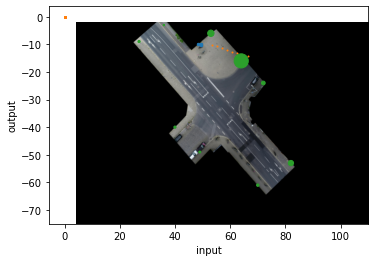

In [51]:
for i in range(1):
    fig1, ax1 = plt.subplots()
    scene_data.plot_on_image([nxt_sc[0]["in_xy"][i], nxt_sc[0]["labels"][i]], 
    save_path='data/images/final_notebook/example_prediction.png', ms = [6, 1], ax=ax1,
    col_num_dicts=[my_ds.generalised_in_dict,my_ds.generalised_out_dict], axes_labels=["input", "output"])
    
    dest_locs = nxt_sc[0]["all_destinations"][i][:, 0:2]
    dest_probs = nxt_sc[0]["all_destinations"][i][:, 2:3]
    
    scene_data.plot_dest_probs(dest_locs, dest_probs, 2, 200,
    ax = ax1)

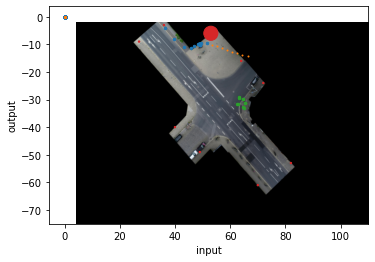

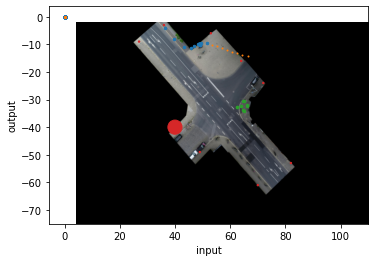

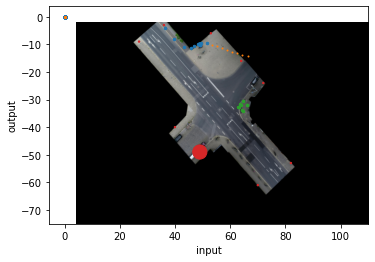

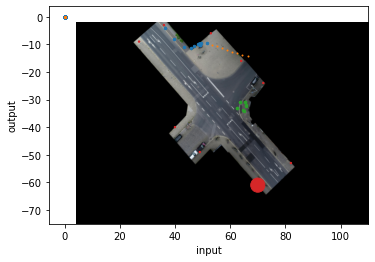

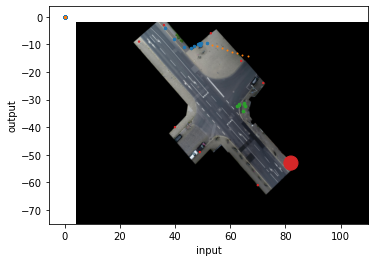

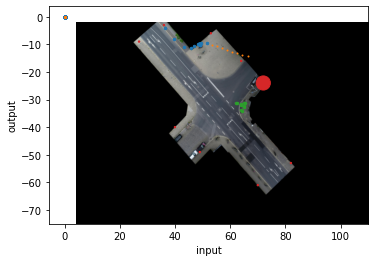

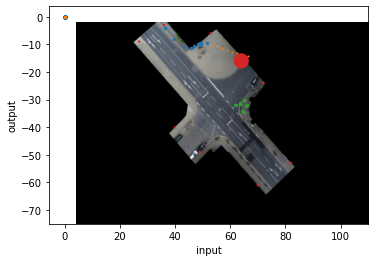

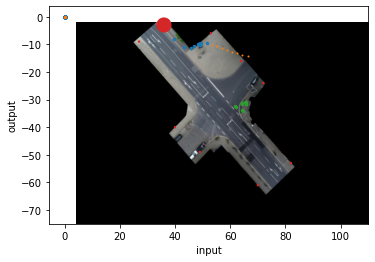

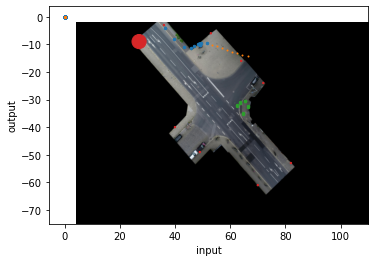

In [52]:
# PLOT BASIC PREDICTION
# create dicts for correctly displaying data    
for i in range(9):
    fig1, ax1 = plt.subplots()
    scene_data.plot_on_image([unscaled_ex[0]["input_labels"], unscaled_ex[0]["labels"], assembled_output[i]], 
    save_path='data/images/final_notebook/example_prediction.png', ms = [6, 1, 6], ax=ax1,
    col_num_dicts=[my_ds.generalised_in_dict, my_ds.generalised_out_dict,my_ds.generalised_out_dict], axes_labels=["input", "output", "prediction"])
    
    dest_locs = destination_list[i][:, :, 0:2]
    dest_probs = destination_list[i][:, :, 2:3]
    
    scene_data.plot_dest_probs(dest_locs[0], dest_probs[0], 2, 200,
    ax = ax1)